# DATA SOURCE:
+ https://github.com/nflverse/nfldata

# Comparison:
+ https://www.nfeloapp.com/games/nfl-model-performance/#:~:text=About,models%20available%20on%20the%20internet

# Import

In [31]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import missingno as msno

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, fbeta_score, make_scorer, confusion_matrix

import functions as func

import warnings
warnings.filterwarnings("ignore", message="Mean of empty slice")

In [2]:
# Get notebook directory
path = os.getcwd()
# Reading in data and creating DataFrame
df = pd.read_csv(path + "/games.csv", sep=",")
# Set max columns to 200, so df.head() shows all(max 200) columns    
pd.set_option("display.max_columns", 200) 
# Rename qb columns
df = df.rename(columns={"away_qb_name": "away_qb", "home_qb_name": "home_qb"})
# Display head so we can so what we are working with and make sure the import went right
display(df.tail())

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,home_score,location,result,total,overtime,old_game_id,gsis,nfl_detail_id,pfr,pff,espn,ftn,away_rest,home_rest,away_moneyline,home_moneyline,spread_line,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,roof,surface,temp,wind,away_qb_id,home_qb_id,away_qb,home_qb,away_coach,home_coach,referee,stadium_id,stadium
6701,2023_20_TB_DET,2023,DIV,20,2024-01-21,Sunday,15:00,TB,23.0,DET,31.0,Home,8.0,54.0,0.0,2024012100,59502.0,NaN,202401210det,NaN,401547757.0,NaN,6,7,225.0,-278.0,6.0,-102.0,-118.0,49.5,-105.0,-115.0,0,dome,fieldturf,NaN,NaN,00-0034855,00-0033106,Baker Mayfield,Jared Goff,Todd Bowles,Dan Campbell,Bill Vinovich,DET00,Ford Field
6702,2023_20_KC_BUF,2023,DIV,20,2024-01-21,Sunday,18:30,KC,27.0,BUF,24.0,Home,-3.0,51.0,0.0,2024012101,59503.0,NaN,202401210buf,NaN,401547758.0,NaN,8,6,120.0,-142.0,2.5,-110.0,-110.0,45.5,-108.0,-112.0,0,outdoors,a_turf,25.0,11.0,00-0033873,00-0034857,Patrick Mahomes,Josh Allen,Andy Reid,Sean McDermott,Shawn Hochuli,BUF00,New Era Field
6703,2023_21_KC_BAL,2023,CON,21,2024-01-28,Sunday,15:00,KC,17.0,BAL,10.0,Home,-7.0,27.0,0.0,2024012800,59504.0,NaN,202401280rav,NaN,401547379.0,NaN,7,8,180.0,-218.0,4.5,-110.0,-112.0,44.0,-105.0,-115.0,0,outdoors,grass,47.0,7.0,00-0033873,00-0034796,Patrick Mahomes,Lamar Jackson,Andy Reid,John Harbaugh,Shawn Smith,BAL00,M&T Bank Stadium
6704,2023_21_DET_SF,2023,CON,21,2024-01-28,Sunday,18:30,DET,31.0,SF,34.0,Home,3.0,65.0,0.0,2024012801,59505.0,NaN,202401280sfo,NaN,401547380.0,NaN,7,8,260.0,-325.0,7.5,-120.0,100.0,52.5,-110.0,-110.0,0,outdoors,grass,69.0,5.0,00-0033106,00-0037834,Jared Goff,Brock Purdy,Dan Campbell,Kyle Shanahan,Clete Blakeman,SFO01,Levi's Stadium
6705,2023_22_SF_KC,2023,SB,22,2024-02-11,Sunday,18:30,SF,NaN,KC,NaN,Neutral,NaN,NaN,NaN,2024021100,NaN,NaN,202402110kan,NaN,NaN,NaN,14,14,-125.0,105.0,-2.0,-105.0,-115.0,47.5,-110.0,-110.0,0,dome,grass,NaN,NaN,00-0037834,00-0033873,Brock Purdy,Patrick Mahomes,Kyle Shanahan,Andy Reid,NaN,VEG00,Allegiant Stadium


In [3]:
# Inserting missing data for Super Bowl
# SF @ KC
sf_kc = {"temp": 49,
         "wind": 5,
         "referee": "Bill Vinovich"}
          
for key, value in sf_kc.items():
    df.loc[6705, key] = value

In [4]:
display(df.tail(1))

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,home_score,location,result,total,overtime,old_game_id,gsis,nfl_detail_id,pfr,pff,espn,ftn,away_rest,home_rest,away_moneyline,home_moneyline,spread_line,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,roof,surface,temp,wind,away_qb_id,home_qb_id,away_qb,home_qb,away_coach,home_coach,referee,stadium_id,stadium
6705,2023_22_SF_KC,2023,SB,22,2024-02-11,Sunday,18:30,SF,NaN,KC,NaN,Neutral,NaN,NaN,NaN,2024021100,NaN,NaN,202402110kan,NaN,NaN,NaN,14,14,-125.0,105.0,-2.0,-105.0,-115.0,47.5,-110.0,-110.0,0,dome,grass,49.0,5.0,00-0037834,00-0033873,Brock Purdy,Patrick Mahomes,Kyle Shanahan,Andy Reid,Bill Vinovich,VEG00,Allegiant Stadium


# EDA

In [5]:
display(df.describe())
print(df.info())

,season,week,away_score,home_score,result,total,overtime,old_game_id,gsis,pff,espn,ftn,away_rest,home_rest,away_moneyline,home_moneyline,spread_line,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,temp,wind
count,6706.000000,6706.000000,6705.000000,6705.000000,6705.000000,6705.000000,6705.000000,6.706000e+03,6.705000e+03,4292.000000,6.705000e+03,1104.000000,6706.000000,6706.000000,4725.000000,4725.000000,6706.000000,4725.000000,4725.000000,6706.000000,4722.000000,4722.000000,6706.000000,4835.000000,4835.000000
mean,2011.128989,9.568744,20.873826,23.234303,2.360477,44.108128,0.061148,2.011306e+09,3.409781e+05,6197.638164,3.185381e+08,5610.425725,7.472413,7.522070,84.182646,-131.236402,2.313376,-53.781799,-53.357037,43.458768,-69.074333,-78.334180,0.378467,57.913754,8.523268
std,7.231956,5.318138,10.066495,10.317679,14.617639,14.209231,0.239620,7.247401e+06,2.441328e+07,6075.412083,7.595231e+07,319.042811,1.976951,2.098159,288.131768,327.504268,5.962381,93.293442,93.628225,4.958611,80.421766,72.270173,0.485041,16.989928,5.418027
min,1999.000000,1.000000,0.000000,0.000000,-49.000000,3.000000,0.000000,1.999091e+09,5.880000e+02,731.000000,1.909120e+08,5058.000000,4.000000,4.000000,-1500.000000,-5000.000000,-19.000000,-137.000000,-146.000000,28.500000,-125.000000,-125.000000,0.000000,-6.000000,0.000000
25%,2005.000000,5.000000,14.000000,16.000000,-7.000000,34.000000,0.000000,2.005102e+09,2.862400e+04,2062.750000,2.510230e+08,5334.750000,7.000000,7.000000,-145.000000,-275.000000,-3.000000,-110.000000,-110.000000,40.000000,-109.000000,-110.000000,0.000000,46.000000,5.000000
50%,2011.000000,10.000000,20.000000,23.000000,3.000000,43.000000,0.000000,2.011113e+09,5.533700e+04,3415.500000,3.111270e+08,5610.500000,7.000000,7.000000,140.000000,-155.000000,3.000000,-105.000000,-105.000000,43.500000,-105.000000,-106.000000,0.000000,59.000000,8.000000
75%,2017.000000,14.000000,27.000000,30.000000,11.000000,53.000000,0.000000,2.017123e+09,5.748100e+04,9352.250000,4.009518e+08,5886.250000,7.000000,7.000000,242.000000,131.000000,6.500000,100.000000,100.000000,47.000000,-102.000000,-102.000000,1.000000,71.000000,12.000000
max,2023.000000,22.000000,59.000000,70.000000,59.000000,106.000000,1.000000,2.024021e+09,1.999101e+09,21536.000000,4.015478e+08,6163.000000,21.000000,16.000000,2173.000000,1100.000000,27.000000,138.000000,126.000000,63.500000,113.000000,113.000000,1.000000,109.000000,71.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6706 entries, 0 to 6705
Data columns (total 46 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   game_id           6706 non-null   object 
 1   season            6706 non-null   int64  
 2   game_type         6706 non-null   object 
 3   week              6706 non-null   int64  
 4   gameday           6706 non-null   object 
 5   weekday           6706 non-null   object 
 6   gametime          6447 non-null   object 
 7   away_team         6706 non-null   object 
 8   away_score        6705 non-null   float64
 9   home_team         6706 non-null   object 
 10  home_score        6705 non-null   float64
 11  location          6706 non-null   object 
 12  result            6705 non-null   float64
 13  total             6705 non-null   float64
 14  overtime          6705 non-null   float64
 15  old_game_id       6706 non-null   int64  
 16  gsis              6705 non-null   float64


In [6]:
# Set columns for missingno NaN overview
df_msno = df.drop(columns=['old_game_id', 'gsis','nfl_detail_id', 'pfr', 'pff', 
                           'espn', 'ftn', 'away_moneyline', 'home_moneyline', 'spread_line',
                           'away_spread_odds', 'home_spread_odds', 'total_line', 'under_odds', 'over_odds'])

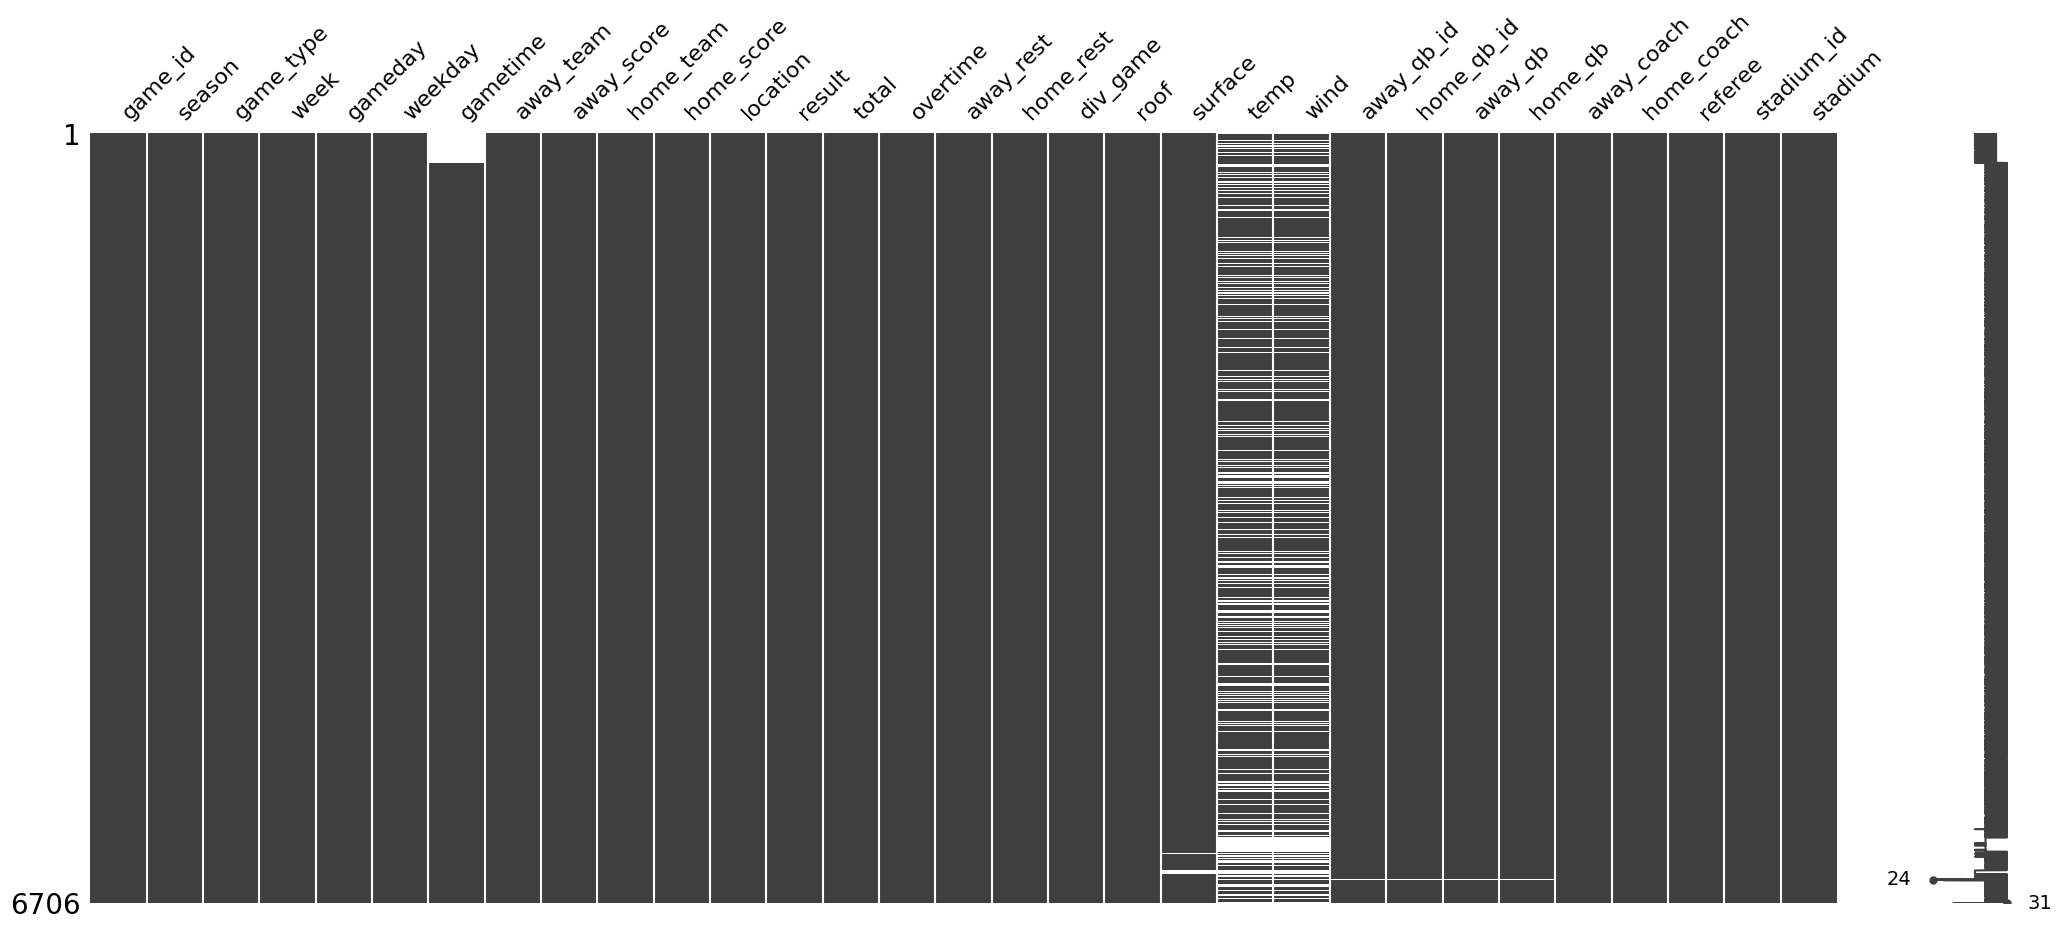

In [7]:
# Missingno NaN overview
msno.matrix(df_msno);
plt.savefig(path + '/media/missing.png', dpi=150)

<Axes: >

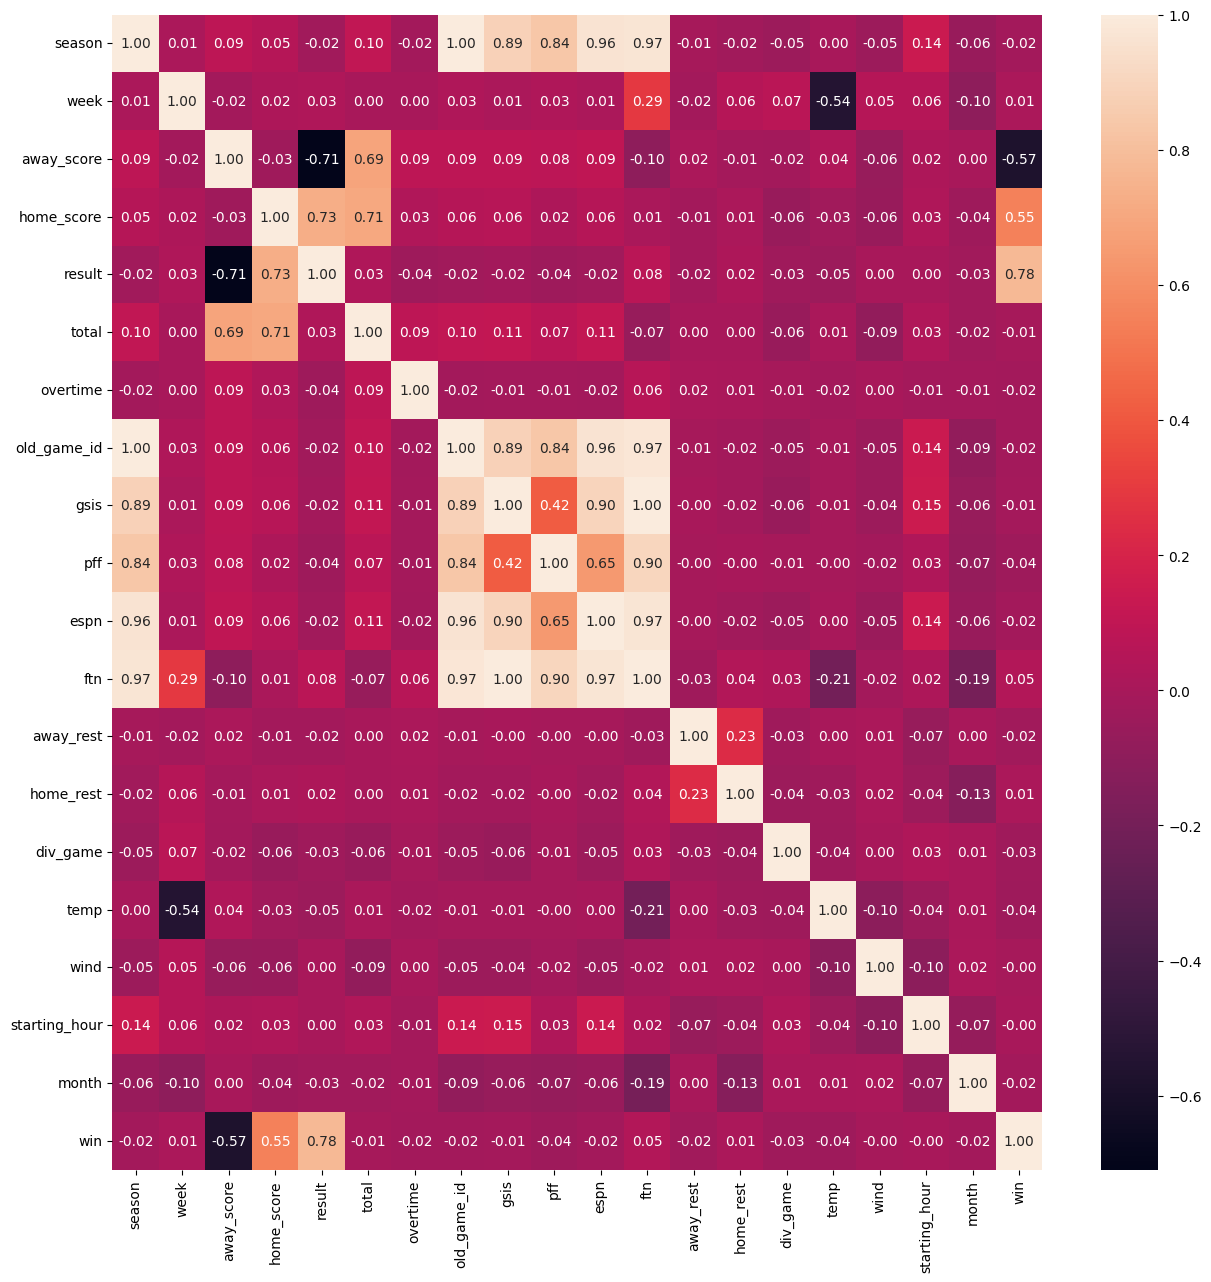

In [8]:
# Clean the DataFrame
df_clean = func.clean_df(df)
# Split columns into categorical and numerical cols for future use (Cat for Onehotencoding - Num for Scaling)
num_cols = df_clean.select_dtypes(include=[np.number]).columns
cat_cols = df_clean.select_dtypes(exclude=[np.number]).columns

# Pairplot
#sns.pairplot(df_clean)

# Create correlation matrix
fig, ax = plt.subplots(figsize=(15, 15))
corr = df_clean[num_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', ax=ax)

win
1    3633
0    2814
Name: count, dtype: int64


<Axes: xlabel='win'>

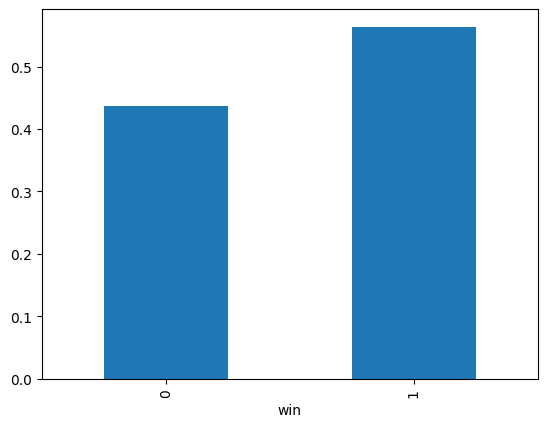

In [9]:
# Check target distribution
print(df_clean["win"].value_counts())
pd.crosstab(index=df_clean["win"], columns="count", normalize="columns").plot(kind="bar", legend=False)

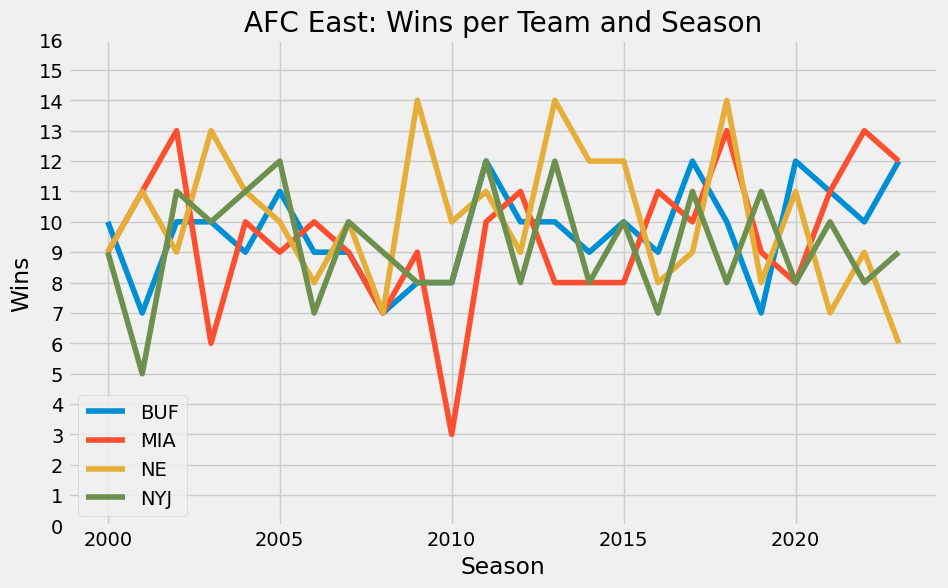

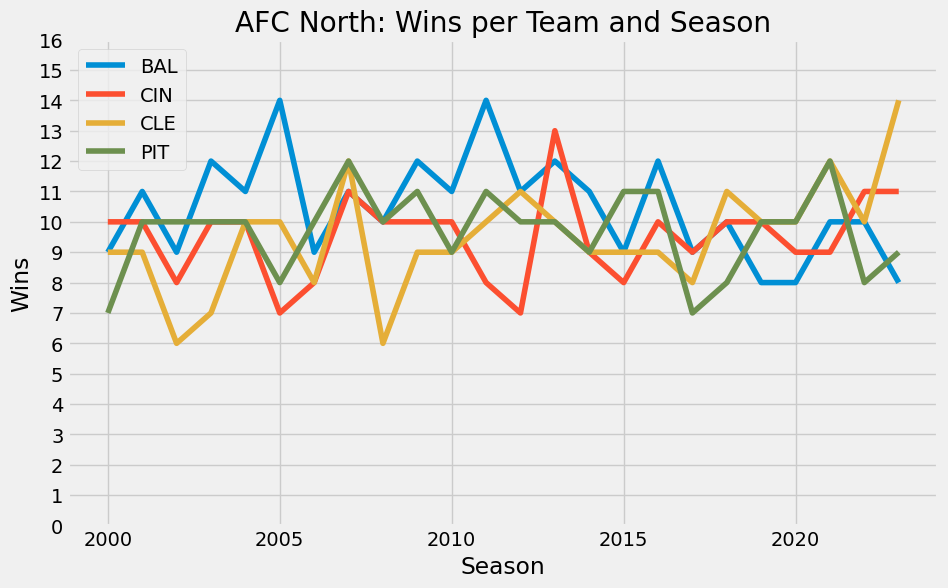

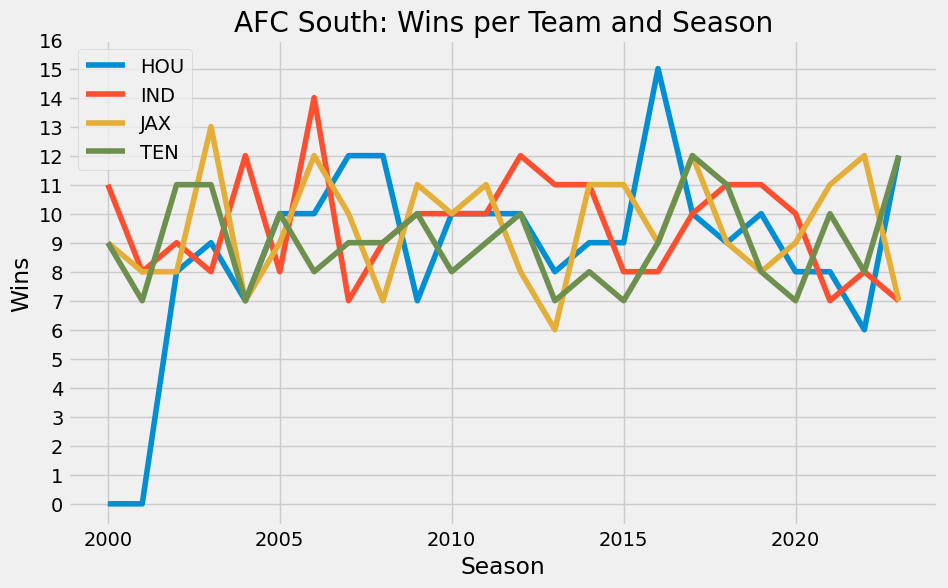

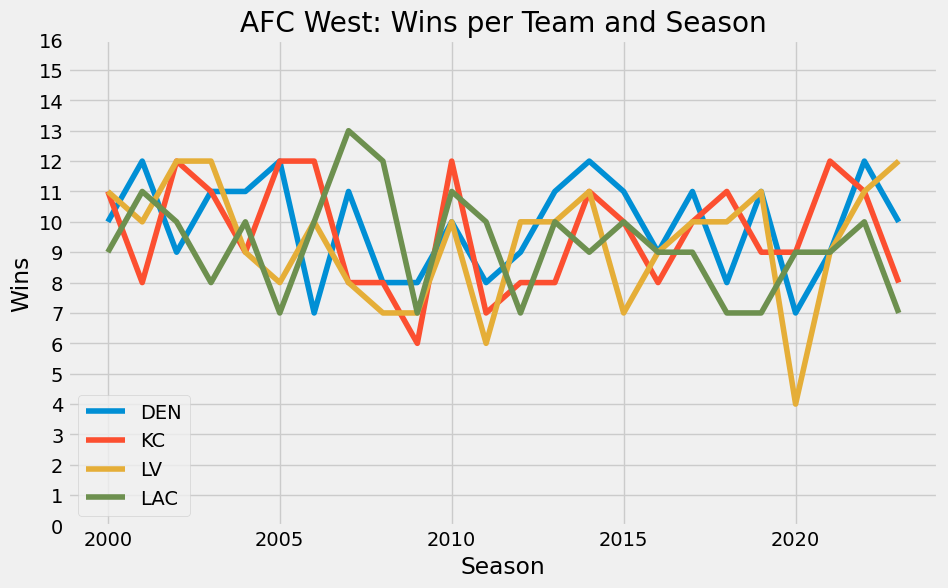

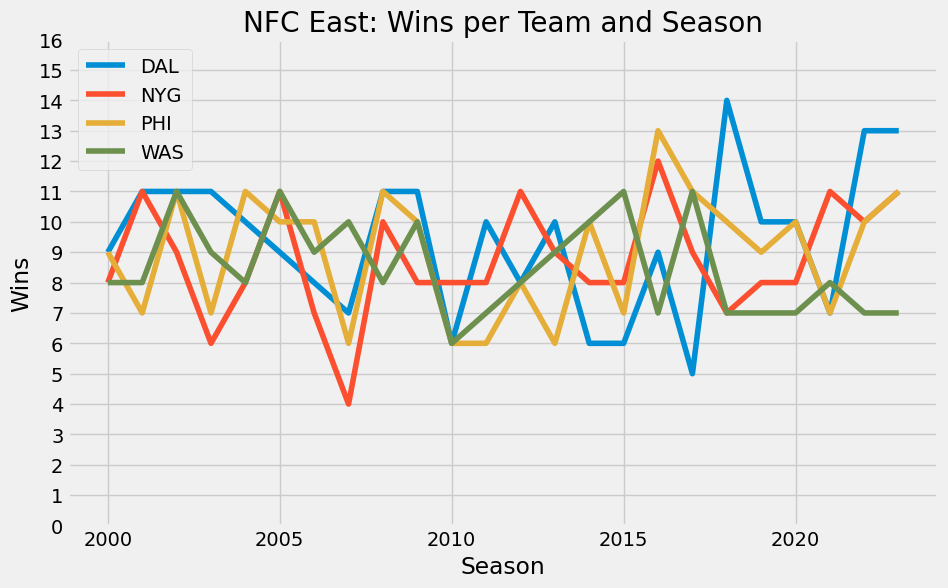

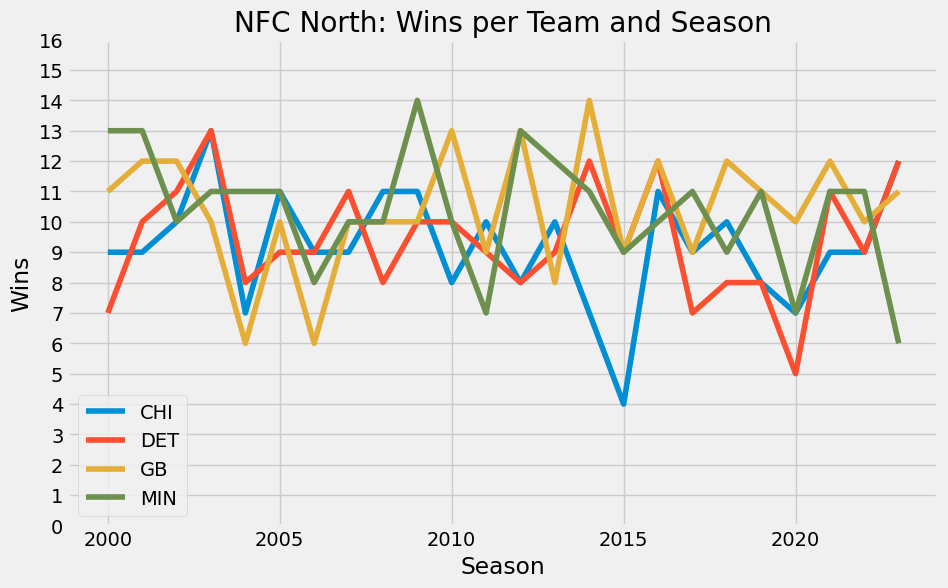

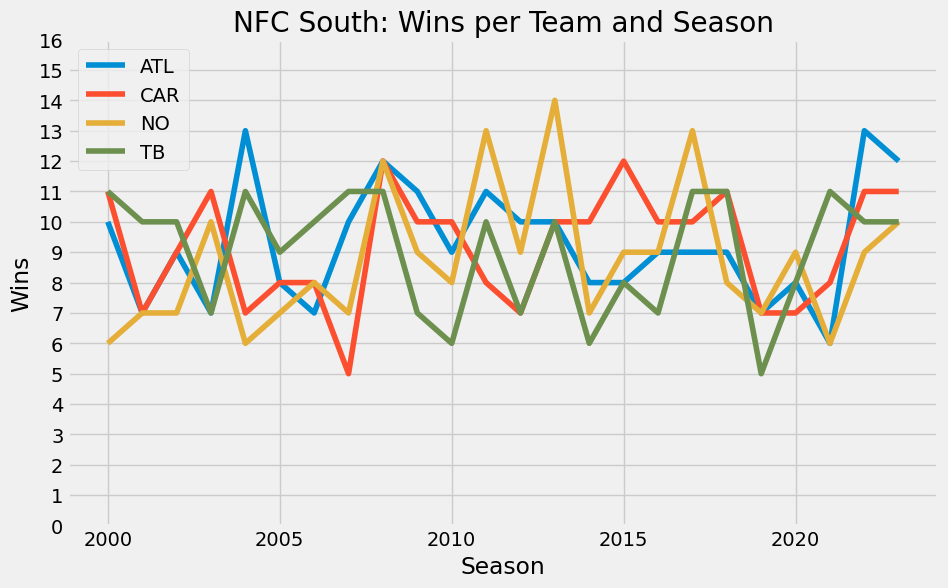

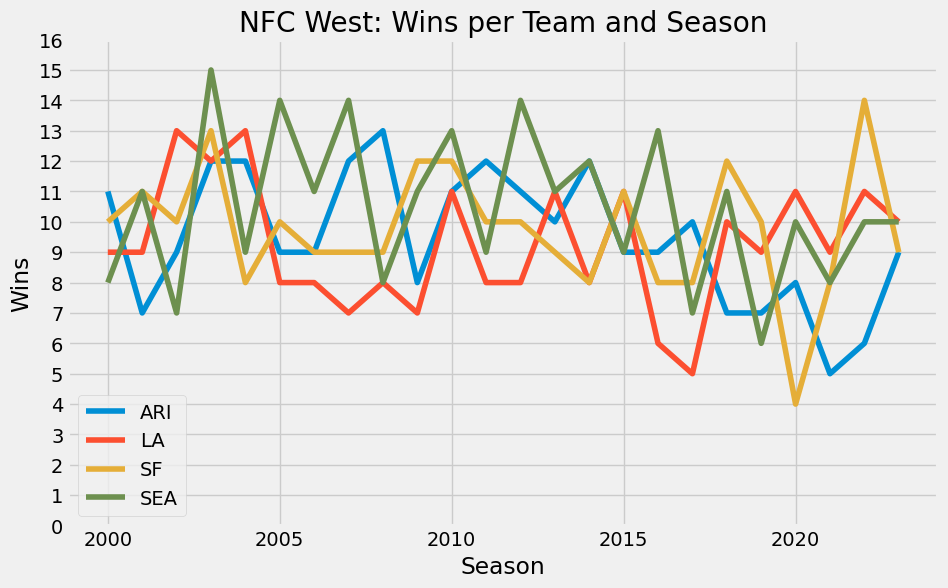

In [10]:
nfl_divisions = [
    # AFC East
    ['BUF', 'MIA', 'NE', 'NYJ'],
    
    # AFC North
    ['BAL', 'CIN', 'CLE', 'PIT'],
    
    # AFC South
    ['HOU', 'IND', 'JAX', 'TEN'],
    
    # AFC West
    ['DEN', 'KC', 'LV', 'LAC'],
    
    # NFC East
    ['DAL', 'NYG', 'PHI', 'WAS'],
    
    # NFC North
    ['CHI', 'DET', 'GB', 'MIN'],
    
    # NFC South
    ['ATL', 'CAR', 'NO', 'TB'],
    
    # NFC West
    ['ARI', 'LA', 'SF', 'SEA']
]
div_names = ["AFC East", "AFC North", "AFC South", "AFC West", "NFC East", "NFC North", "NFC South", "NFC West"]

# Create a new DataFrame to store wins per team
team_wins_season = pd.DataFrame(columns=["team", "wins"])

# Calculate and store wins for each team and season
for team in set(df_clean["away_team"].unique()).union(set(df_clean["home_team"].unique())):
    for season in df_clean["season"].unique():
        total_wins = df_clean[(df_clean["away_team"] == team) & (df_clean["season"] == season)]["win"].sum() + \
                     df_clean[(df_clean["home_team"] == team) & (df_clean["season"] == season)]["win"].sum()
        team_wins_season = pd.concat([team_wins_season, pd.DataFrame({"team": [team], "season": [season], "wins": [total_wins]})], ignore_index=True)

# Sort the DataFrame by wins and season
team_wins_season = team_wins_season.sort_values(by=["team", "season"])

# Plotting
#fig, axs = plt.subplots(nrows=4, ncols=2)
plt.style.use('fivethirtyeight')
i = 0
for div in nfl_divisions:
    plt.figure(figsize=(10, 6))
    for team in div:
        team_data = team_wins_season[team_wins_season["team"] == team]
        plt.plot(team_data["season"], team_data["wins"], label=team)

        plt.title("{}: Wins per Team and Season".format(div_names[i]))
        plt.yticks(range(0, 17, 1))
        plt.xlabel("Season")
        plt.ylabel("Wins")
        plt.legend()
        plt.savefig(path + "/media/{}_Wins_Season.jpg".format(div_names[i], dpi=150))
    i += 1
plt.show()

# Basemodel

In [11]:
df_base = df_clean[['season', 'game_type', 'week', 'away_team', 'home_team', 'location', 
              'away_rest', 'home_rest', 'div_game','roof', 'surface', 'temp', 'wind', 
              'win']]
print(df_base.info())
df_base.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6447 entries, 0 to 6446
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   season     6447 non-null   int64  
 1   game_type  6447 non-null   object 
 2   week       6447 non-null   int64  
 3   away_team  6447 non-null   object 
 4   home_team  6447 non-null   object 
 5   location   6447 non-null   object 
 6   away_rest  6447 non-null   int64  
 7   home_rest  6447 non-null   int64  
 8   div_game   6447 non-null   int64  
 9   roof       6447 non-null   object 
 10  surface    6447 non-null   object 
 11  temp       6447 non-null   float64
 12  wind       6447 non-null   float64
 13  win        6447 non-null   int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 705.3+ KB
None


,season,game_type,week,away_team,home_team,location,away_rest,home_rest,div_game,roof,surface,temp,wind,win
0,2000,REG,1,SF,ATL,Home,7,7,1,dome,synthetic,61.2,8.4,1
1,2000,REG,1,JAX,CLE,Home,7,7,1,outdoors,grass,78.0,6.0,0
2,2000,REG,1,IND,KC,Home,7,7,0,outdoors,grass,90.0,5.0,0
3,2000,REG,1,CHI,MIN,Home,7,7,1,dome,synthetic,61.2,8.9,1
4,2000,REG,1,TB,NE,Home,7,7,0,outdoors,grass,71.0,5.0,0


In [12]:
features_train_base, target_train_base, features_test_base, target_test_base = func.train_test_split(df_base)
features_train_base, features_test_base = func.pipeline(features_train_base, features_test_base)
features_train_base.head()

,season,week,away_rest,home_rest,div_game,temp,wind,game_type_CON,game_type_DIV,game_type_REG,game_type_SB,game_type_WC,away_team_ARI,away_team_ATL,away_team_BAL,away_team_BUF,away_team_CAR,away_team_CHI,away_team_CIN,away_team_CLE,away_team_DAL,away_team_DEN,away_team_DET,away_team_GB,away_team_HOU,away_team_IND,away_team_JAX,away_team_KC,away_team_LA,away_team_LAC,away_team_LV,away_team_MIA,away_team_MIN,away_team_NE,away_team_NO,away_team_NYG,away_team_NYJ,away_team_PHI,away_team_PIT,away_team_SEA,away_team_SF,away_team_TB,away_team_TEN,away_team_WAS,home_team_ARI,home_team_ATL,home_team_BAL,home_team_BUF,home_team_CAR,home_team_CHI,home_team_CIN,home_team_CLE,home_team_DAL,home_team_DEN,home_team_DET,home_team_GB,home_team_HOU,home_team_IND,home_team_JAX,home_team_KC,home_team_LA,home_team_LAC,home_team_LV,home_team_MIA,home_team_MIN,home_team_NE,home_team_NO,home_team_NYG,home_team_NYJ,home_team_PHI,home_team_PIT,home_team_SEA,home_team_SF,home_team_TB,home_team_TEN,home_team_WAS,location_Home,location_Neutral,roof_closed,roof_dome,roof_open,roof_outdoors,surface_grass,surface_synthetic
0,-1.655814,-1.614715,-0.249337,-0.248942,1.282501,0.153364,0.013511,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-1.655814,-1.614715,-0.249337,-0.248942,1.282501,1.286128,-0.486579,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,-1.655814,-1.614715,-0.249337,-0.248942,-0.779727,2.095246,-0.694949,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,-1.655814,-1.614715,-0.249337,-0.248942,1.282501,0.153364,0.117697,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-1.655814,-1.614715,-0.249337,-0.248942,-0.779727,0.814143,-0.694949,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [13]:
param_grid = {"C": [0.1, 1, 10, 1000],
              "penalty": ["l1", "l2"]}


grid_log_base = GridSearchCV(LogisticRegression(max_iter=1000,
                                               solver="saga"),
                                               param_grid,
                                               cv=5,
                                               scoring="accuracy",
                                               n_jobs=-1)

# Fit on Train Data
grid_log_base.fit(features_train_base, target_train_base)
# Predict Target Test
target_test_base_pred = grid_log_base.predict(features_test_base)
# Print Metrics
print("-----LogReg-----")
print("Best Parameter: {}".format(grid_log_base.best_params_))
print(classification_report(target_test_base, target_test_base_pred))   

-----LogReg-----
Best Parameter: {'C': 0.1, 'penalty': 'l1'}
              precision    recall  f1-score   support

           0       0.49      0.15      0.23       522
           1       0.54      0.86      0.66       601

    accuracy                           0.53      1123
   macro avg       0.51      0.51      0.45      1123
weighted avg       0.52      0.53      0.46      1123



In [14]:
search_space_rf = {'max_depth': np.geomspace(start=5, stop=200, num=20, dtype='int'),
                   'min_samples_leaf': np.geomspace(start=1, stop=500, num=10, dtype='int')}


grid_dtc_base = GridSearchCV(DecisionTreeClassifier(),
                            search_space_rf,
                            cv=5,
                            scoring="accuracy",
                            n_jobs=-1)

# Fit on Train Data
grid_dtc_base.fit(features_train_base, target_train_base)
# Predict Target Test
target_test_base_pred = grid_dtc_base.predict(features_test_base)
# Print Metrics
print("-----DecisionTree -----")
print("Best Parameter: {}".format(grid_dtc_base.best_params_))
print(classification_report(target_test_base, target_test_base_pred))                                          

-----DecisionTree -----
Best Parameter: {'max_depth': np.int64(6), 'min_samples_leaf': np.int64(125)}
              precision    recall  f1-score   support

           0       0.36      0.05      0.08       522
           1       0.53      0.93      0.67       601

    accuracy                           0.52      1123
   macro avg       0.44      0.49      0.38      1123
weighted avg       0.45      0.52      0.40      1123



In [15]:
search_space_rf = {'max_depth': np.geomspace(start=20, stop=30, num=10, dtype='int'),
                   'min_samples_leaf': np.geomspace(start=20, stop=60, num=10, dtype='int')}

model_rf_base = GridSearchCV(estimator=RandomForestClassifier(n_estimators=50,
                                                         random_state=42),
                                                         param_grid=search_space_rf,
                                                         scoring='accuracy',
                                                         cv=5,
                                                         n_jobs=-1)
                                                                                 
# Fit on Train Data
model_rf_base.fit(features_train_base, target_train_base)
# Predict Target Test
target_test_base_pred = model_rf_base.predict(features_test_base)
# Print Metrics
print("-----RandomForest-----")
print("Best Parameter: {}".format(model_rf_base.best_params_))
print(classification_report(target_test_base, target_test_base_pred))

-----RandomForest-----
Best Parameter: {'max_depth': np.int64(25), 'min_samples_leaf': np.int64(32)}
              precision    recall  f1-score   support

           0       0.48      0.20      0.28       522
           1       0.54      0.81      0.65       601

    accuracy                           0.53      1123
   macro avg       0.51      0.51      0.47      1123
weighted avg       0.51      0.53      0.48      1123



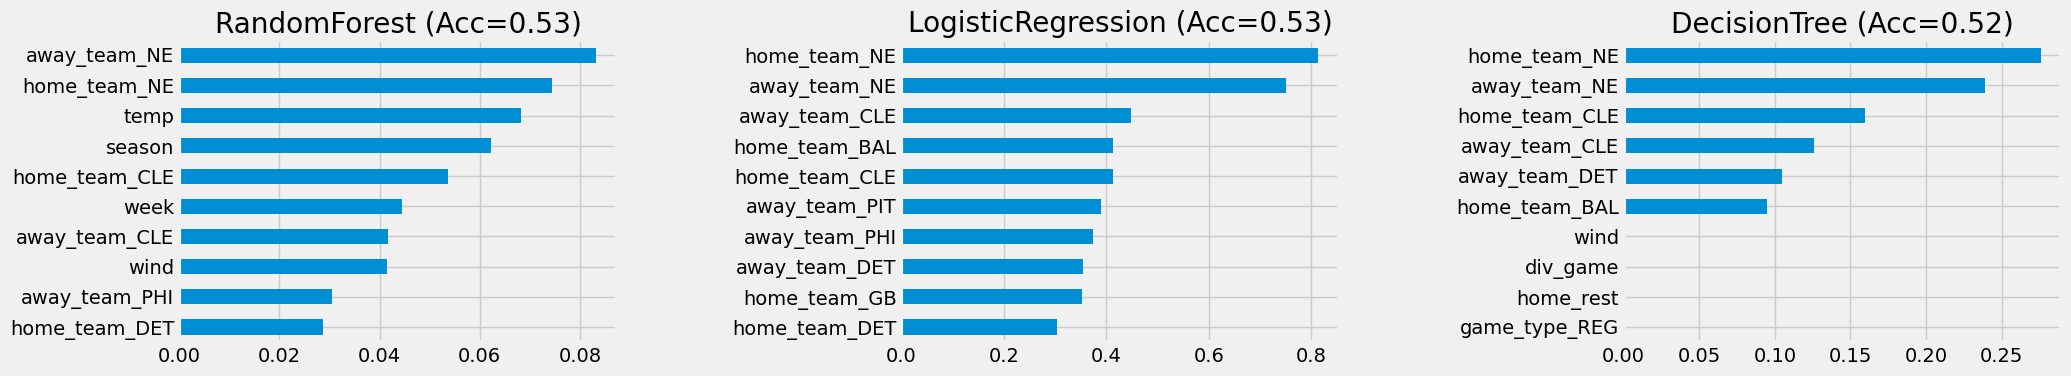

In [16]:
# Feature Importance of the best models
fig, axs = plt.subplots(ncols=3, figsize=(24, 8))
fig.tight_layout(pad=12)

fi_rf_base = model_rf_base.best_estimator_.feature_importances_
feature_importance_rf_base = pd.Series(fi_rf_base, index=features_test_base.columns)
feature_importance_rf_base.sort_values(ascending=False)[:10].plot(kind='barh', title="RandomForest (Acc=0.53)", ax=axs[0]).invert_yaxis()

fi_base = grid_log_base.best_estimator_.coef_[0]
feature_importance_base = pd.Series(np.abs(fi_base), index=features_test_base.columns)
feature_importance_base.sort_values(ascending=False)[:10].plot(kind='barh', title="LogisticRegression (Acc=0.53)", ax=axs[1]).invert_yaxis()

fi_base = grid_dtc_base.best_estimator_.feature_importances_
feature_importance_base = pd.Series(fi_base, index=features_test_base.columns)
feature_importance_base.sort_values(ascending=False)[:10].plot(kind='barh', title="DecisionTree (Acc=0.52)", ax=axs[2]).invert_yaxis()

plt.savefig(path + "/media/Feature_Importances_Base.jpg", dpi=150)

# Feature Engineering

## Hard Reset

In [17]:
df_eng = func.feature_eng(df)
df_eng = df_eng.drop(columns=["home_team", "away_team", "away_qb", "home_qb", "away_coach", "home_coach", "referee", "stadium"])
features_train_eng, target_train_eng, features_test_eng, target_test_eng = func.train_test_split(df_eng)
features_train_eng, features_test_eng = func.pipeline(features_train_eng, features_test_eng)
features_train_eng.head()

,season,month,week,starting_hour,away_elo,home_elo,away_avg_points,away_avg_points_allowed,home_avg_points,home_avg_points_allowed,away_rest,home_rest,div_game,temp,wind,away_qb_elo,home_qb_elo,away_coach_elo,home_coach_elo,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,game_type_CON,game_type_DIV,game_type_REG,game_type_SB,game_type_WC,location_Home,location_Neutral,roof_closed,roof_dome,roof_open,roof_outdoors,surface_grass,surface_synthetic
0,-1.655814,-0.384161,-1.614715,-0.692312,-0.084087,-0.054765,-3.976117,-4.248718,-3.905384,-4.277631,-0.249337,-0.248942,1.282501,0.153364,0.013511,-0.237854,-0.198189,-0.105146,-0.073636,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-1.655814,-0.384161,-1.614715,-0.692312,-0.084087,-0.054765,-3.976117,-4.248718,-3.905384,-4.277631,-0.249337,-0.248942,1.282501,1.286128,-0.486579,-0.237854,-0.198189,-0.105146,-0.073636,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,-1.655814,-0.384161,-1.614715,-0.692312,-0.084087,-0.054765,-3.976117,-4.248718,-3.905384,-4.277631,-0.249337,-0.248942,-0.779727,2.095246,-0.694949,-0.237854,-0.198189,-0.105146,-0.073636,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,-1.655814,-0.384161,-1.614715,-0.692312,-0.084087,-0.054765,-3.976117,-4.248718,-3.905384,-4.277631,-0.249337,-0.248942,1.282501,0.153364,0.117697,-0.237854,-0.198189,-0.105146,-0.073636,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-1.655814,-0.384161,-1.614715,-0.692312,-0.084087,-0.054765,-3.976117,-4.248718,-3.905384,-4.277631,-0.249337,-0.248942,-0.779727,0.814143,-0.694949,-0.237854,-0.198189,-0.105146,-0.073636,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [18]:
param_grid = {"C": [0.1, 1, 10, 1000],
              "penalty": ["l1", "l2"]}


grid_log_eng = GridSearchCV(LogisticRegression(max_iter=1000,
                                               solver="saga"),
                                               param_grid,
                                               cv=5,
                                               scoring="accuracy",
                                               n_jobs=-1)

# Fit on Train Data
grid_log_eng.fit(features_train_eng, target_train_eng)
# Predict Target Test
target_test_eng_pred = grid_log_eng.predict(features_test_eng)
# Print Metrics
print("-----LogReg-----")
print("Best Parameter: {}".format(grid_log_eng.best_params_))
print(classification_report(target_test_eng, target_test_eng_pred))   

-----LogReg-----
Best Parameter: {'C': 10, 'penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.60      0.43      0.50       522
           1       0.60      0.76      0.67       601

    accuracy                           0.60      1123
   macro avg       0.60      0.59      0.59      1123
weighted avg       0.60      0.60      0.59      1123



In [19]:
search_space_rf = {'max_depth': np.geomspace(start=5, stop=200, num=20, dtype='int'),
                   'min_samples_leaf': np.geomspace(start=1, stop=500, num=10, dtype='int')}


grid_dtc_eng = GridSearchCV(DecisionTreeClassifier(),
                            search_space_rf,
                            cv=5,
                            scoring="accuracy",
                            n_jobs=-1)

# Fit on Train Data
grid_dtc_eng.fit(features_train_eng, target_train_eng)
# Predict Target Test
target_test_eng_pred = grid_dtc_eng.predict(features_test_eng)
# Print Metrics
print("-----DecisionTree -----")
print("Best Parameter: {}".format(grid_dtc_eng.best_params_))
print(classification_report(target_test_eng, target_test_eng_pred))                                             

-----DecisionTree -----
Best Parameter: {'max_depth': np.int64(5), 'min_samples_leaf': np.int64(250)}
              precision    recall  f1-score   support

           0       0.59      0.49      0.53       522
           1       0.61      0.71      0.66       601

    accuracy                           0.60      1123
   macro avg       0.60      0.60      0.59      1123
weighted avg       0.60      0.60      0.60      1123



In [20]:
search_space_rf = {'max_depth': np.geomspace(start=4, stop=100, num=20, dtype='int'),
                   'min_samples_leaf': np.geomspace(start=1, stop=200, num=20, dtype='int')}

model_rf_eng = GridSearchCV(estimator=RandomForestClassifier(n_estimators=50,
                                                         random_state=42),
                                                         param_grid=search_space_rf,
                                                         scoring='accuracy',
                                                         cv=5,
                                                         n_jobs=-1)
                                                                                 
# Fit on Train Data
model_rf_eng.fit(features_train_eng, target_train_eng)
# Predict Target Test
target_test_eng_pred = model_rf_eng.predict(features_test_eng)
# Print Metrics
print("-----RandomForest-----")
print("Best Parameter: {}".format(model_rf_eng.best_params_))
print(classification_report(target_test_eng, target_test_eng_pred))

c:\Users\Eventh\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


-----RandomForest-----
Best Parameter: {'max_depth': np.int64(13), 'min_samples_leaf': np.int64(28)}
              precision    recall  f1-score   support

           0       0.62      0.39      0.48       522
           1       0.60      0.79      0.68       601

    accuracy                           0.61      1123
   macro avg       0.61      0.59      0.58      1123
weighted avg       0.61      0.61      0.59      1123



## Soft Reset

In [21]:
df_eng_soft = func.feature_eng(df, alpha=1)
df_eng_soft = df_eng_soft.drop(columns=["home_team", "away_team", "away_qb", "home_qb", "away_coach", "home_coach", "referee", "stadium"])
features_train_eng_soft, target_train_eng_soft, features_test_eng_soft, target_test_eng_soft = func.train_test_split(df_eng_soft)
features_train_eng_soft, features_test_eng_soft = func.pipeline(features_train_eng_soft, features_test_eng_soft)
features_train_eng_soft.head()

,season,month,week,starting_hour,away_elo,home_elo,away_avg_points,away_avg_points_allowed,home_avg_points,home_avg_points_allowed,away_rest,home_rest,div_game,temp,wind,away_qb_elo,home_qb_elo,away_coach_elo,home_coach_elo,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,game_type_CON,game_type_DIV,game_type_REG,game_type_SB,game_type_WC,location_Home,location_Neutral,roof_closed,roof_dome,roof_open,roof_outdoors,surface_grass,surface_synthetic
0,-1.655814,-0.384161,-1.614715,-0.692312,-0.049292,-0.038277,-3.976117,-4.248718,-3.905384,-4.277631,-0.249337,-0.248942,1.282501,0.153364,0.013511,-0.690366,-0.66277,-0.662618,-0.634805,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-1.655814,-0.384161,-1.614715,-0.692312,-0.049292,-0.038277,-3.976117,-4.248718,-3.905384,-4.277631,-0.249337,-0.248942,1.282501,1.286128,-0.486579,-0.690366,-0.66277,-0.662618,-0.634805,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,-1.655814,-0.384161,-1.614715,-0.692312,-0.049292,-0.038277,-3.976117,-4.248718,-3.905384,-4.277631,-0.249337,-0.248942,-0.779727,2.095246,-0.694949,-0.690366,-0.66277,-0.662618,-0.634805,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,-1.655814,-0.384161,-1.614715,-0.692312,-0.049292,-0.038277,-3.976117,-4.248718,-3.905384,-4.277631,-0.249337,-0.248942,1.282501,0.153364,0.117697,-0.690366,-0.66277,-0.662618,-0.634805,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-1.655814,-0.384161,-1.614715,-0.692312,-0.049292,-0.038277,-3.976117,-4.248718,-3.905384,-4.277631,-0.249337,-0.248942,-0.779727,0.814143,-0.694949,-0.690366,-0.66277,-0.662618,-0.634805,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [36]:
param_grid = {"C": [0.1, 1, 10, 1000],
              "penalty": ["l1", "l2"]}


grid_log_eng_soft = GridSearchCV(LogisticRegression(max_iter=1000,
                                               solver="saga"),
                                               param_grid,
                                               cv=5,
                                               scoring="accuracy",
                                               n_jobs=-1)

# Fit on Train Data
grid_log_eng_soft.fit(features_train_eng_soft, target_train_eng_soft)
# Predict Target Test
target_test_eng_soft_pred = grid_log_eng_soft.predict(features_test_eng_soft)
# Print Metrics
print("-----LogReg-----")
print("Best Parameter: {}".format(grid_log_eng_soft.best_params_))
print(classification_report(target_test_eng_soft, target_test_eng_soft_pred))
acc_log_soft = accuracy_score(target_test_eng_soft, target_test_eng_soft_pred)
print(acc_log_soft)

-----LogReg-----
Best Parameter: {'C': 0.1, 'penalty': 'l1'}
              precision    recall  f1-score   support

           0       0.65      0.45      0.53       522
           1       0.62      0.79      0.70       601

    accuracy                           0.63      1123
   macro avg       0.64      0.62      0.62      1123
weighted avg       0.64      0.63      0.62      1123

0.6340160284951024


In [23]:
search_space_rf = {'max_depth': np.geomspace(start=5, stop=200, num=20, dtype='int'),
                   'min_samples_leaf': np.geomspace(start=1, stop=500, num=10, dtype='int')}


grid_dtc_eng_soft = GridSearchCV(DecisionTreeClassifier(),
                            search_space_rf,
                            cv=5,
                            scoring="accuracy",
                            n_jobs=-1)

# Fit on Train Data
grid_dtc_eng_soft.fit(features_train_eng_soft, target_train_eng_soft)
# Predict Target Test
target_test_eng_soft_pred = grid_dtc_eng_soft.predict(features_test_eng_soft)
# Print Metrics
print("-----DecisionTree -----")
print("Best Parameter: {}".format(grid_dtc_eng_soft.best_params_))
print(classification_report(target_test_eng_soft, target_test_eng_soft_pred))                                             

-----DecisionTree -----
Best Parameter: {'max_depth': np.int64(7), 'min_samples_leaf': np.int64(125)}
              precision    recall  f1-score   support

           0       0.60      0.45      0.51       522
           1       0.61      0.73      0.66       601

    accuracy                           0.60      1123
   macro avg       0.60      0.59      0.59      1123
weighted avg       0.60      0.60      0.59      1123



c:\Users\Eventh\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [35]:
search_space_rf = {'max_depth': np.geomspace(start=4, stop=100, num=20, dtype='int'),
                   'min_samples_leaf': np.geomspace(start=1, stop=200, num=20, dtype='int')}

model_rf_eng_soft = GridSearchCV(estimator=RandomForestClassifier(n_estimators=50,
                                                         random_state=42),
                                                         param_grid=search_space_rf,
                                                         scoring='accuracy',
                                                         cv=5,
                                                         n_jobs=-1)
                                                                                 
# Fit on Train Data
model_rf_eng_soft.fit(features_train_eng_soft, target_train_eng_soft)
# Predict Target Test
target_test_eng_soft_pred = model_rf_eng_soft.predict(features_test_eng_soft)
# Print Metrics
print("-----RandomForest-----")
print("Best Parameter: {}".format(model_rf_eng_soft.best_params_))
print(classification_report(target_test_eng_soft, target_test_eng_soft_pred))
acc_rf_soft = accuracy_score(target_test_eng_soft, target_test_eng_soft_pred)
print(acc_rf_soft)

c:\Users\Eventh\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


-----RandomForest-----
Best Parameter: {'max_depth': np.int64(7), 'min_samples_leaf': np.int64(21)}
              precision    recall  f1-score   support

           0       0.64      0.42      0.51       522
           1       0.61      0.79      0.69       601

    accuracy                           0.62      1123
   macro avg       0.62      0.61      0.60      1123
weighted avg       0.62      0.62      0.60      1123

0.6188780053428317


## Best Settings

In [ ]:
# the best rf model for real 
df_eng_best = func.feature_eng(df, alpha=0.7, week_change=1)
df_eng_best = df_eng_best.drop(columns=["home_team", "away_team", "away_qb", "home_qb", "away_coach", "home_coach", "referee", "stadium"])
features_train_eng_best, target_train_eng_best, features_test_eng_best, target_test_eng_best = func.train_test_split(df_eng_best, split_season=2023)
features_train_eng_best, features_test_eng_best = func.pipeline(features_train_eng_best, features_test_eng_best)

#search_space_rf = {'max_depth': np.geomspace(start=4, stop=100, num=10, dtype='int'),
#                   'min_samples_leaf': np.geomspace(start=1, stop=200, num=10, dtype='int')}

# Smaller search space
search_space_rf = {'max_depth': [10, 16],
                   'min_samples_leaf': [34, 36]}

model_rf_eng_best = GridSearchCV(estimator=RandomForestClassifier(n_estimators=100,
                                                                     random_state=42),
                                                                     param_grid=search_space_rf,
                                                                     scoring='accuracy',
                                                                     cv=5,
                                                                     n_jobs=-1)
                                                                                 
# Fit on Train Data
model_rf_eng_best.fit(features_train_eng_best, target_train_eng_best)
# Predict Target Test
target_test_eng_best_pred = model_rf_eng_best.predict(features_test_eng_best)
# Print Metrics
print("-----RandomForest-----")
print("Best Parameter: {}".format(model_rf_eng_best.best_params_))
print(classification_report(target_test_eng_best, target_test_eng_best_pred))

-----RandomForest-----
Best Parameter: {'max_depth': 16, 'min_samples_leaf': 36}
              precision    recall  f1-score   support

           0       0.65      0.55      0.60       125
           1       0.69      0.77      0.73       160

    accuracy                           0.67       285
   macro avg       0.67      0.66      0.66       285
weighted avg       0.67      0.67      0.67       285



In [34]:
model_rf_eng_best = RandomForestClassifier(max_depth=16,
                                              min_samples_leaf=36,
                                              n_estimators=100,
                                              random_state=42)
# Fit on Train Data
model_rf_eng_best.fit(features_train_eng_best, target_train_eng_best)
# Predict Target Test
target_test_eng_best_pred = model_rf_eng_best.predict(features_test_eng_best)
# Print Metrics
print("-----RandomForest-----")
#print("Best Parameter: {}".format(model_rf_eng_best.best_params_))
print(classification_report(target_test_eng_best, target_test_eng_best_pred))
acc_rf_best = accuracy_score(target_test_eng_best, target_test_eng_best_pred)
print(acc_rf_best)

-----RandomForest-----
              precision    recall  f1-score   support

           0       0.65      0.55      0.60       125
           1       0.69      0.77      0.73       160

    accuracy                           0.67       285
   macro avg       0.67      0.66      0.66       285
weighted avg       0.67      0.67      0.67       285

0.6736842105263158


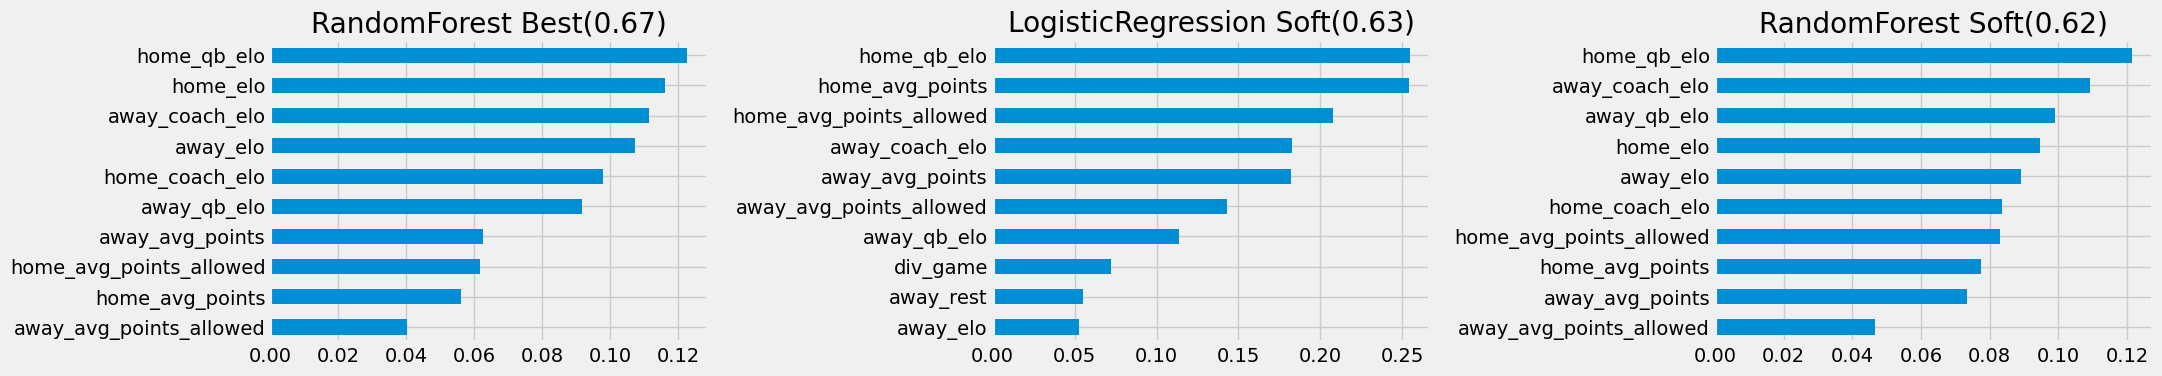

In [39]:
# Feature Importance of the best models
fig, axs = plt.subplots(ncols=3, figsize=(24, 8))
fig.tight_layout(pad=12)

fi_rf_best = model_rf_eng_best.feature_importances_
feature_importance_rf_best = pd.Series(fi_rf_best, index=features_test_eng_best.columns)
feature_importance_rf_best.sort_values(ascending=False)[:10].plot(kind='barh', title="RandomForest Best({:.2f})".format(acc_rf_best), ax=axs[0]).invert_yaxis()

fi_log = grid_log_eng_soft.best_estimator_.coef_[0]
feature_importance_log = pd.Series(np.abs(fi_log), index=features_test_eng_soft.columns)
feature_importance_log.sort_values(ascending=False)[:10].plot(kind='barh', title="LogisticRegression Soft({:.2f})".format(acc_log_soft), ax=axs[1]).invert_yaxis()

fi_dtc = model_rf_eng_soft.best_estimator_.feature_importances_
feature_importance_dtc = pd.Series(fi_dtc, index=features_test_eng_soft.columns)
feature_importance_dtc.sort_values(ascending=False)[:10].plot(kind='barh', title="RandomForest Soft({:.2f})".format(acc_rf_soft), ax=axs[2]).invert_yaxis()

plt.savefig(path + "/media/Feature_Importances_Engineered.jpg", dpi=150)

# Predicted Result

In [45]:
target_test_eng_best_pred_proba = model_rf_eng_best.predict_proba(features_test_eng_best)

In [46]:
df_2023_pred = df.loc[df["season"] == 2023]

In [47]:
df_2023_pred.loc[:, ["away_%"]] = target_test_eng_best_pred_proba[:, 0]
df_2023_pred.loc[:, ["home_%"]] = target_test_eng_best_pred_proba[:, 1]
df_2023_pred = df_2023_pred[["season", "week", "weekday", "game_type", "away_team", "home_team", "away_%", "home_%"]]
df_2023_pred

,season,week,weekday,game_type,away_team,home_team,away_%,home_%
6421,2023,1,Thursday,REG,DET,KC,0.285277,0.714723
6422,2023,1,Sunday,REG,CAR,ATL,0.482493,0.517507
6423,2023,1,Sunday,REG,HOU,BAL,0.313824,0.686176
6424,2023,1,Sunday,REG,CIN,CLE,0.602778,0.397222
6425,2023,1,Sunday,REG,JAX,IND,0.532591,0.467409
...,...,...,...,...,...,...,...,...
6701,2023,20,Sunday,DIV,TB,DET,0.348079,0.651921
6702,2023,20,Sunday,DIV,KC,BUF,0.348178,0.651822
6703,2023,21,Sunday,CON,KC,BAL,0.375947,0.624053
6704,2023,21,Sunday,CON,DET,SF,0.380175,0.619825


# Super Bowl Prediction

In [43]:
df_2023_pred.loc[[6705]]

,season,week,weekday,game_type,away_team,home_team,away_%,home_%
6705,2023,22,Sunday,SB,SF,KC,0.472245,0.527755
